   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
3               NaN              NaN                NaN          NaN     NaN
4              36.7             19.3              193.0       3450.0  FEMALE
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


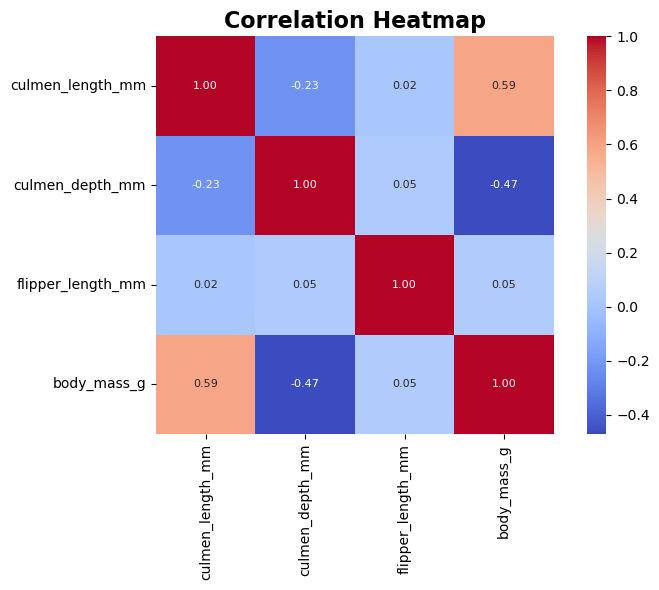

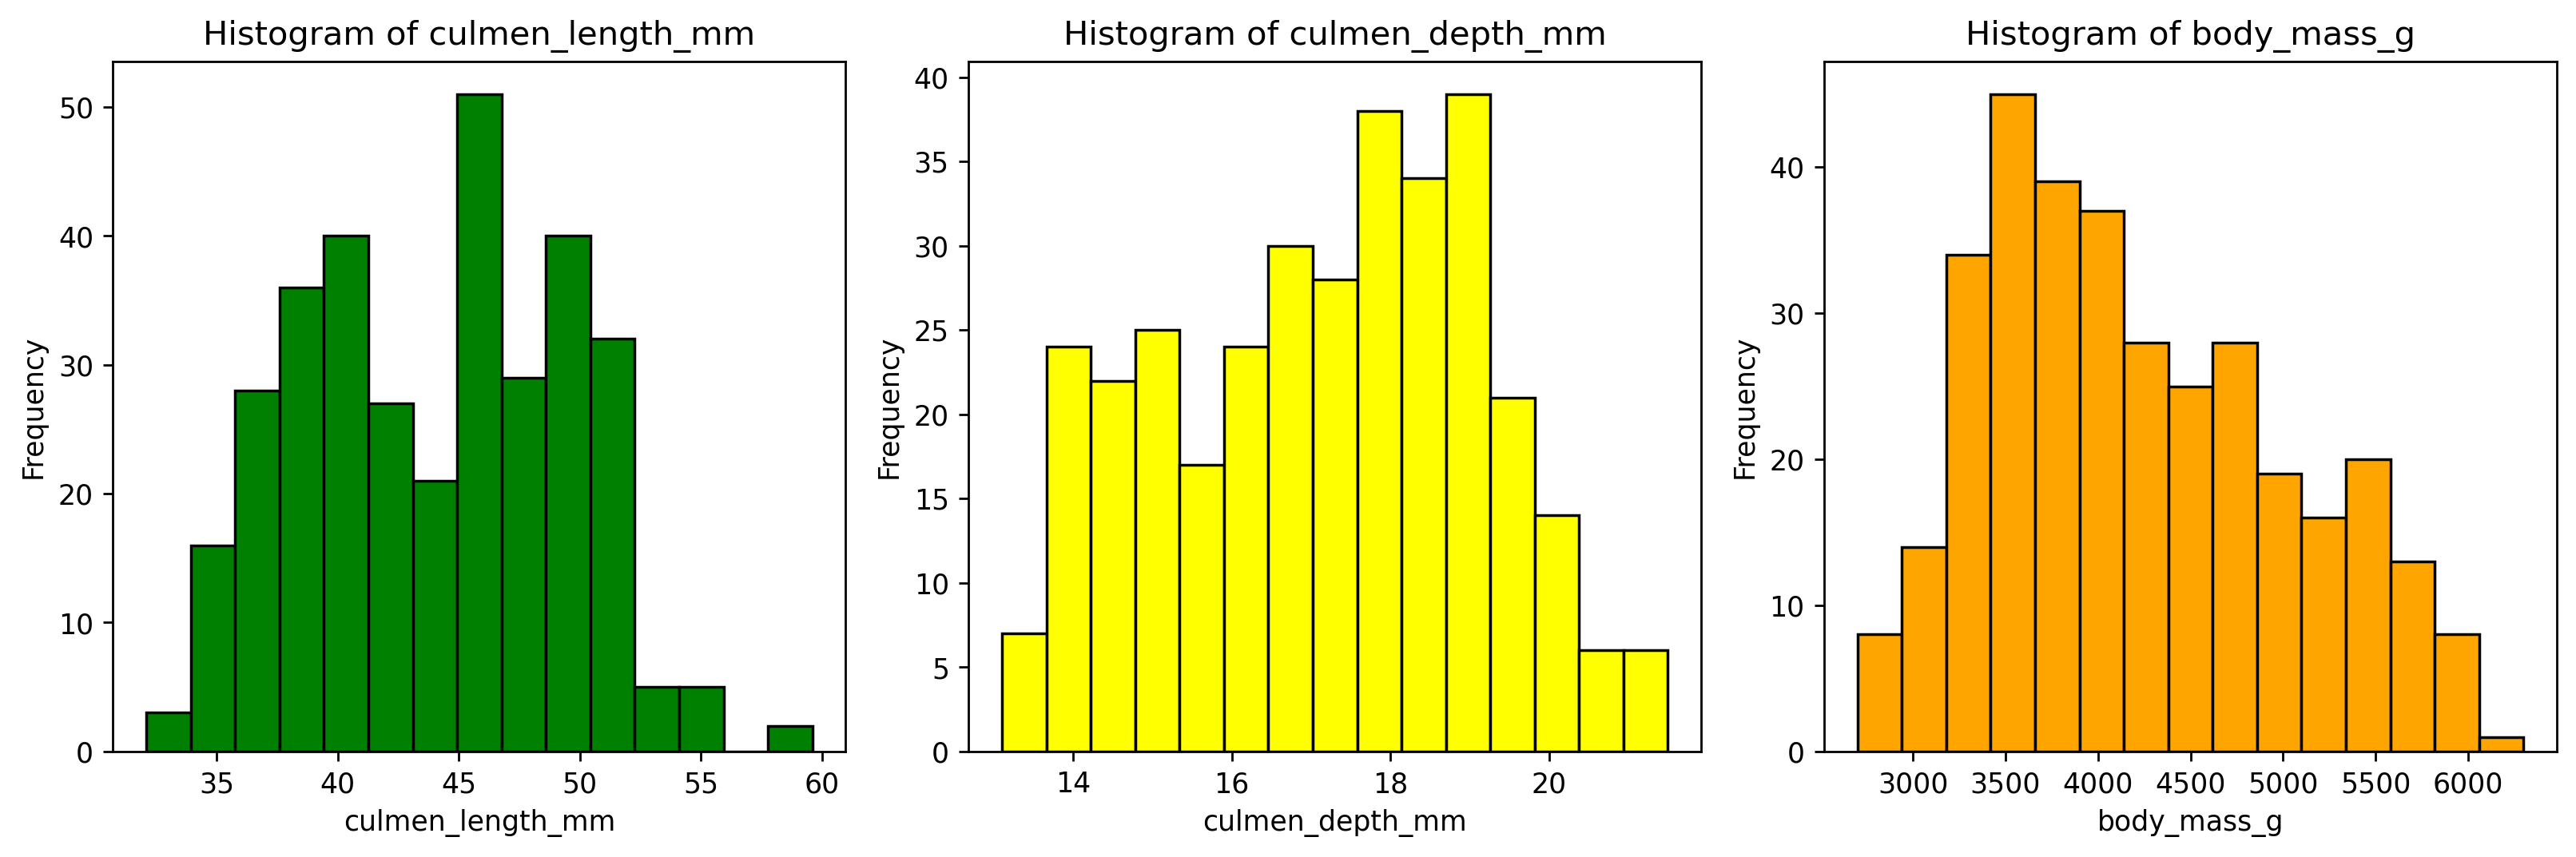

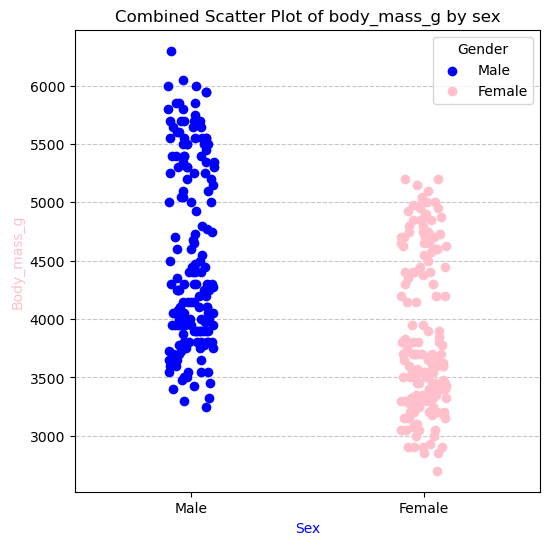

Number of components with more than 10% variance: 3


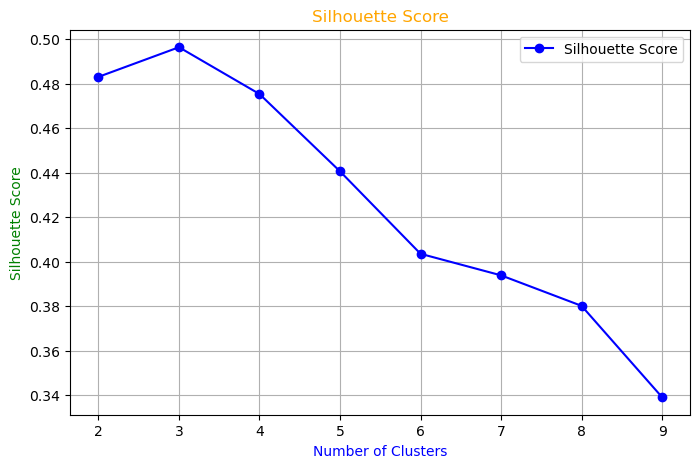

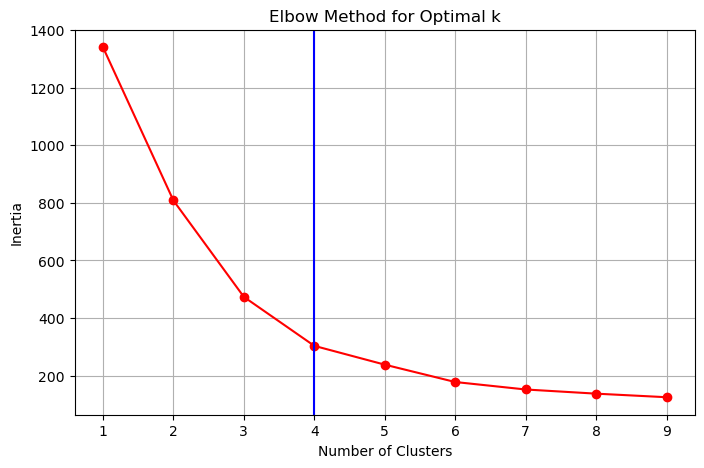

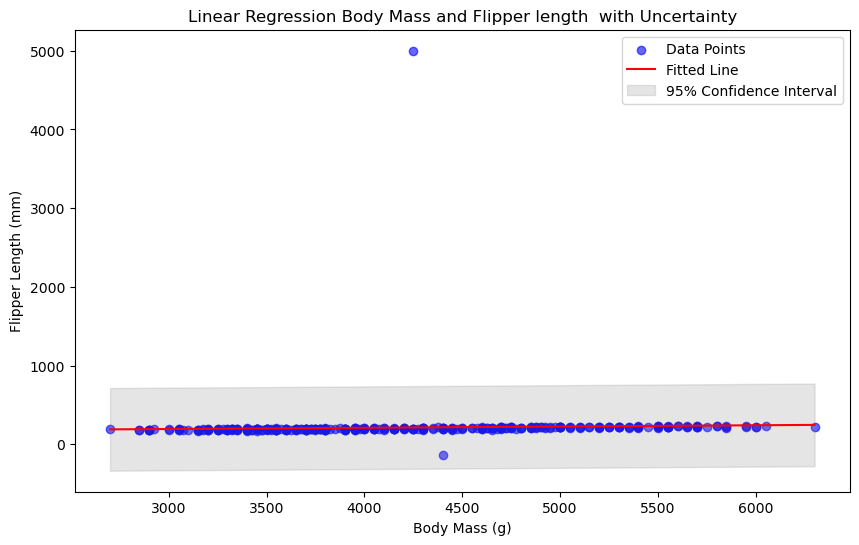

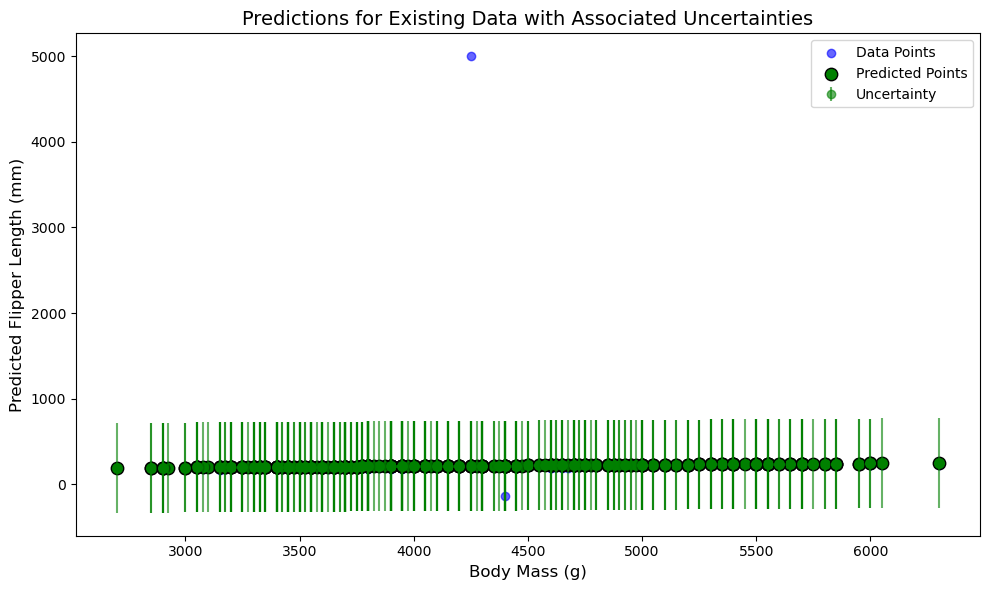

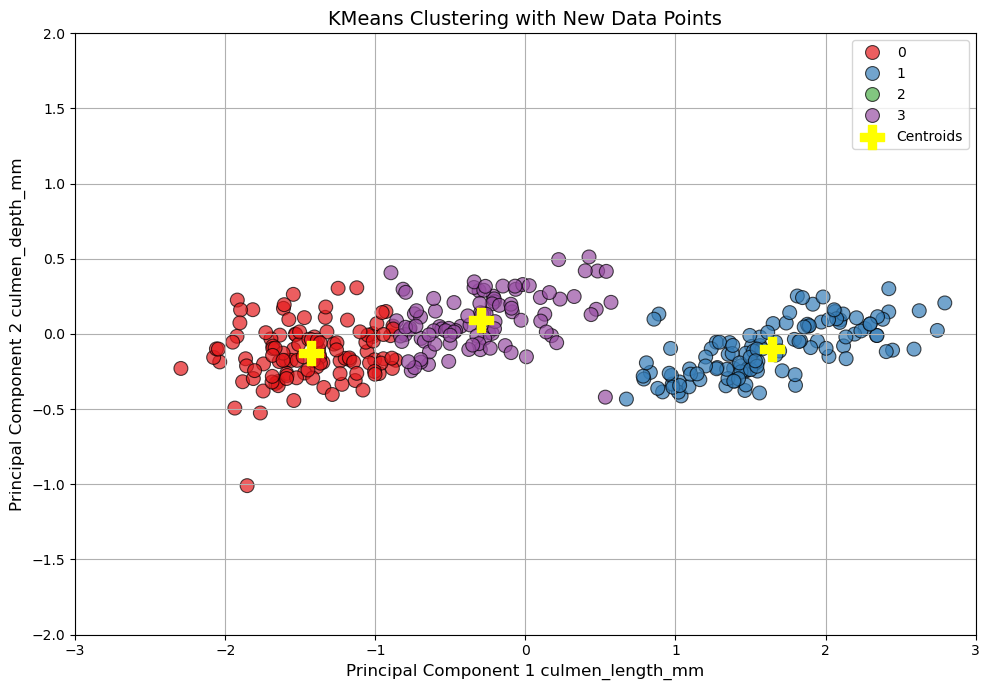

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
import math
import warnings
warnings.filterwarnings("ignore")

#scatter plot
def scatter_plot_combined(dataframe, numerical_column, categorical_column):
    """
    Create a combined scatter plot for male and female entries based on a categorical column.

    Parameters:
    dataframe : pandas.DataFrame
        The DataFrame containing the data to be plotted.
    numerical_column : str
        The name of the numerical column (y-axis).
    categorical_column : str
        The name of the categorical column used to filter the data
    """
    dataframe[categorical_column] = dataframe[categorical_column].str.strip().str.capitalize()
    male_data = dataframe[dataframe[categorical_column] == 'Male']
    female_data = dataframe[dataframe[categorical_column] == 'Female']
    plt.figure(figsize=(6, 6))
    sns.stripplot(data=male_data, x=categorical_column, y=numerical_column, jitter=True, color="blue", label="Male", size=7)
    sns.stripplot(data=female_data, x=categorical_column, y=numerical_column, jitter=True, color="pink", label="Female", size=7)
    plt.title(f'Combined Scatter Plot of {numerical_column} by {categorical_column}')
    plt.xlabel(categorical_column.capitalize(),color='blue')
    plt.ylabel(numerical_column.capitalize(),color='pink')
    plt.legend(title="Gender")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

#coorelation matrix
def plot_correlation_heatmap(data):
    """
    Plot a heatmap showing correlations between numerical features.

    Parameters:
    data (DataFrame): Dataset to analyze.
    """
    numeric_data = data.select_dtypes(include='number')
    correlation_matrix = numeric_data.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",cbar=True, square=True, annot_kws={"size": 8})  # Increase font size for annotations
    plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
#histogram
def plot_colored_histograms(dataframe, columns, colors=None, bins=10):
    """
    Plot individual histograms for a list of numerical columns with customizable colors.

    Parameters:
    dataframe : pandas.DataFrame
        The DataFrame containing the data to be plotted.
    columns : list of str
        The list of numerical column names to create histograms for.
    colors : list of str, optional
        A list of colors for the histograms. If not provided, default matplotlib colors are used.
    bins : int, optional
        Number of bins for the histogram (default is 10).
    """
    plt.figure(figsize=(13, 8), dpi=250)
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i + 1)  # Adjust subplot layout (2 rows, 3 columns)
        plt.hist(dataframe[col], bins=bins, color=colors[i] if colors else 'blue', edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout() 
    plt.show()

#calculate statics of all numeric data
def calculate_numeric_statistics(df):
    """
    Calculate summary statistics for numeric columns in the DataFrame.

    This function computes the following statistics for each numeric column:
    - Count,Mean,Standard Deviation,Min,25th percentile,50th percentile (Median),75th percentile,Max
    - Skewness,Kurtosis

    Parameters:df (pandas.DataFrame): The input DataFrame containing numeric columns.
    Returns:pandas.DataFrame: A DataFrame containing the computed statistics.
    """
    num_columns = df.select_dtypes(include=['int', 'float']).columns
    summary_stats = df[num_columns].describe().transpose()
    median_values = df[num_columns].median()
    skew_values = df[num_columns].skew()
    kurt_values = df[num_columns].kurtosis()
    stats_df = pd.concat([summary_stats, median_values, skew_values, kurt_values], axis=1)
    stats_df.columns = ['Count', 'Mean', 'Std Dev', 'Min', '25%', '50%', '75%', 'Max', 'Skewness', 'Kurtosis', 'Median']
    return stats_df


def standardize_data(data):
    """
    Standardize the input data using StandardScaler.
    
    Parameters:
    dataframe : pandas.DataFrameThe input DataFrame containing numerical data to be standardized.

    Returns:
    scaled_data : numpy.ndarray  The standardized data.
    """
    numeric_cols = data.select_dtypes(include=np.number).columns
    scaled_data = scaler.fit_transform(data[numeric_cols])
    return scaled_data

def apply_pca(scaled_data):
    """
    Apply Principal Component Analysis (PCA) to reduce the dimensionality of the data.
    
    Parameters:
    scaled_data : numpy.ndarray The standardized data.

    Returns:
    pca_transformed_data : numpy.ndarray Data transformed using PCA.
    explained_variance : numpy.ndarray Explained variance ratio for each PCA component.
    """
    pca = PCA(n_components=None)
    pca_transformed_data = pca.fit_transform(scaled_data)
    explained_variance = pca.explained_variance_ratio_
    return pca_transformed_data, explained_variance

#elbow method
def elbow_analysis(pca_transformed_data, max_clusters=10):
    """
    Perform Elbow analysis to determine the optimal number of clusters.
    
    Parameters:
    pca_transformed_data : numpy.ndarrayThe PCA-transformed data.
    max_clusters : int, optional The maximum number of clusters to consider for the analysis (default is 10).

    Returns:
    optimal_clusters : int
        Optimal number of clusters based on the analysis.
    """
    inertia_list = []
    for k in range(1, max_clusters):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(pca_transformed_data)
        inertia_list.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters), inertia_list, 'ro-')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid()
    plt.axvline(x=4, color='b', linestyle='-')  # Example optimal k
    plt.show()
    return 4
    
#silhouette_analysis
def calculate_silhouette_scores(pca_transformed_data, max_clusters=10):
    """
    Calculate silhouette scores for different numbers of clusters.

    Parameters:
    pca_transformed_data : numpy.ndarray
        The PCA-transformed data.
    max_clusters : int, optional
        The maximum number of clusters to consider for the analysis (default is 10).

    Returns:
    silhouette_scores : list
        A list of silhouette scores for each number of clusters (from 2 to max_clusters - 1).
    cluster_range : list
        The range of cluster numbers considered (from 2 to max_clusters - 1).
    """
    silhouette_scores = []
    cluster_range = range(2, max_clusters)
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(pca_transformed_data)
        silhouette = silhouette_score(pca_transformed_data, labels)
        silhouette_scores.append(silhouette)
    return silhouette_scores, cluster_range

#plot silhouette_scores
def plot_silhouette_scores(silhouette_scores, cluster_range, optimal_clusters=None):
    """
    Plot silhouette scores for a range of cluster numbers.

    Parameters:
    silhouette_scores : list
        A list of silhouette scores for each number of clusters.
    cluster_range : list
        The range of cluster numbers corresponding to the silhouette scores.
    optimal_clusters : int, optional
        The optimal number of clusters to highlight on the plot (default is None).
    """
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, silhouette_scores, 'bo-', label="Silhouette Score")
    plt.title('Silhouette Score',color='Orange')
    plt.xlabel('Number of Clusters',color='blue')
    plt.ylabel('Silhouette Score',color='green')
    plt.legend()
    plt.grid()
    plt.show()

# Linear Regression with Uncertainty
def linear_regression_with_uncertainty(x, y):
    """
    Perform linear regression and show predictions with uncertainties.

    Parameters:
    x (Series or ndarray): Independent variable (e.g., body_mass_g).
    y (Series or ndarray): Dependent variable (e.g., flipper_length_mm).

    Returns:
    LinearRegression: The fitted regression model.
    """
    x = x.values.reshape(-1, 1) if isinstance(x, pd.Series) else x.reshape(-1, 1)
    y = y.values
    regressor = LinearRegression()
    regressor.fit(x, y)
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = regressor.predict(x_range)
    y_std = np.std(y - regressor.predict(x))  # Calculate residual standard deviation
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='blue', alpha=0.6, label='Data Points')
    plt.plot(x_range, y_pred, color='red', label='Fitted Line')
    plt.fill_between(
        x_range.flatten(), 
        y_pred - 2*y_std, 
        y_pred + 2*y_std, 
        color='gray', alpha=0.2, label='95% Confidence Interval'
    )
    plt.xlabel("Body Mass (g)")
    plt.ylabel("Flipper Length (mm)")
    plt.title("Linear Regression Body Mass and Flipper length  with Uncertainty")
    plt.legend()
    plt.show()
    return regressor

# Linear Regression Prediction with Visualization
def linear_regression_predict(x, y, regressor):
    """
    Predict outcomes for existing data points using a fitted linear regression model
    and visualize the results with uncertainties.

    Parameters:
    x (Series or ndarray): Independent variable (e.g., body_mass_g).
    y (Series or ndarray): Dependent variable (e.g., flipper_length_mm).
    regressor (LinearRegression): Fitted regression model.
    """
    x = x.values.reshape(-1, 1) if isinstance(x, pd.Series) else x.reshape(-1, 1)
    y_pred = regressor.predict(x)
    residual_std = np.std(y - y_pred)
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='blue', alpha=0.6, label='Data Points')
    plt.scatter(x, y_pred, color='green', label='Predicted Points', edgecolor='black', s=80)
    plt.errorbar(x.flatten(), y_pred, yerr=2 * residual_std, fmt='o', color='green', alpha=0.6, label='Uncertainty')
    plt.title("Predictions for Existing Data with Associated Uncertainties", fontsize=14)
    plt.xlabel("Body Mass (g)", fontsize=12)
    plt.ylabel("Predicted Flipper Length (mm)", fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# KMeans Clustering and Prediction Visualization
def kmeans_predict_and_visualize(pca_transformed_data, kmeans_model):
    """
    Predict cluster assignments for new data points using a fitted KMeans model 
    and visualize the clusters along with the new points.

    Parameters:
    pca_transformed_data (ndarray): PCA-transformed data used for fitting the model.
    kmeans_model (KMeans): Fitted KMeans clustering model.

    Returns:
    predictions (ndarray): Predicted cluster labels for the new points (if provided).
    """
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=pca_transformed_data[:, 0],
        y=pca_transformed_data[:, 1],
        hue=kmeans_model.labels_,
        palette="Set1",
        s=100,
        alpha=0.7,
        edgecolor='k',
        legend="full"
    )

    # Plot centroids
    plt.scatter(
        kmeans_model.cluster_centers_[:, 0],
        kmeans_model.cluster_centers_[:, 1],
        s=300, c='yellow', marker='P', label='Centroids'
    )
    plt.title("KMeans Clustering with New Data Points", fontsize=14)
    plt.xlim(-3,3)
    plt.ylim(-2,2)
    plt.xlabel("Principal Component 1 culmen_length_mm", fontsize=12)
    plt.ylabel("Principal Component 2 culmen_depth_mm", fontsize=12)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


#______________________Main execution_____________________#
#read data set
df=pd.read_csv('penguins.csv')
print(df.head())

#drop null values of data set
df = df.dropna()
print(df.isnull().sum())

#coorelation matrix
plot_correlation_heatmap(df)

#Histogram
numerical_columns = ['culmen_length_mm', 'culmen_depth_mm', 'body_mass_g']
custom_colors = ['green', 'yellow', 'orange']
plot_colored_histograms(df, numerical_columns, colors=custom_colors, bins=15)

#plot scatter plot
scatter_plot_combined(df, numerical_column='body_mass_g', categorical_column='sex')

#calculate All statics
calculate_numeric_statistics(df)

# Standardize the data
df.drop(columns=['sex'], inplace=True)

# Apply PCA
pca_transformed_data, explained_variance = apply_pca(scaled_data)

# Print PCA components with more than 10% variance
n_components_above_10 = sum(explained_variance > 0.1)
print(f"Number of components with more than 10% variance: {n_components_above_10}")

# Calculate silhouette scores
silhouette_scores, cluster_range = calculate_silhouette_scores(pca_transformed_data, max_clusters=10)

# Plot the silhouette analysis
optimal_clusters = 3
plot_silhouette_scores(silhouette_scores, cluster_range, optimal_clusters=optimal_clusters)

# Perform Elbow analysis and get optimal clusters
optimal_clusters = elbow_analysis(pca_transformed_data)

regressor = linear_regression_with_uncertainty(data['body_mass_g'], data['flipper_length_mm'])
linear_regression_predict(data['body_mass_g'], data['flipper_length_mm'], regressor)

# Prepare Data for Clustering
scaled_data = standardize_data(df)
# Perform PCA for Dimensionality Reduction
pca = PCA(n_components=2)
pca_transformed_data = pca.fit_transform(scaled_data)

# Fit KMeans Model
kmeans_model = KMeans(n_clusters=4, random_state=42).fit(pca_transformed_data)

# Visualize Clusters and Centroids
kmeans_predict_and_visualize(pca_transformed_data, kmeans_model)